In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

In [3]:
print("Loading data...")
try:
    train_df = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
    test_df = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")
    sample_sub_df = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")

    print(f"Train data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    print(f"Sample submission shape: {sample_sub_df.shape}")
except FileNotFoundError:
    print("Make sure train.csv, test.csv, and sample_submission.csv are in the same directory.")

Loading data...
Train data shape: (517754, 14)
Test data shape: (172585, 13)
Sample submission shape: (172585, 2)


In [4]:
print("Training Data Head:")
print(train_df.head())

print("\nTraining Data Info:")
train_df.info()

print("\nTraining Data Description (Numerical):")
print(train_df.describe())

print("\nTraining Data Description (Categorical):")
print(train_df.describe(include=['object', 'bool']))

Training Data Head:
   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1               

In [5]:
print("Test Data Head:")
print(test_df.head())

print("\nTest Data Info:")
test_df.info()

Test Data Head:
       id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0  517754   highway          2       0.34           45     night   clear   
1  517755     urban          3       0.04           45       dim   foggy   
2  517756     urban          2       0.59           35       dim   clear   
3  517757     rural          4       0.95           35  daylight   rainy   
4  517758   highway          2       0.86           35  daylight   clear   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0                True         True   afternoon     True           True   
1                True        False   afternoon     True          False   
2                True        False   afternoon     True           True   
3               False        False   afternoon    False          False   
4                True        False     evening    False           True   

   num_reported_accidents  
0                       1  
1                       0 

Generated target_distribution.png


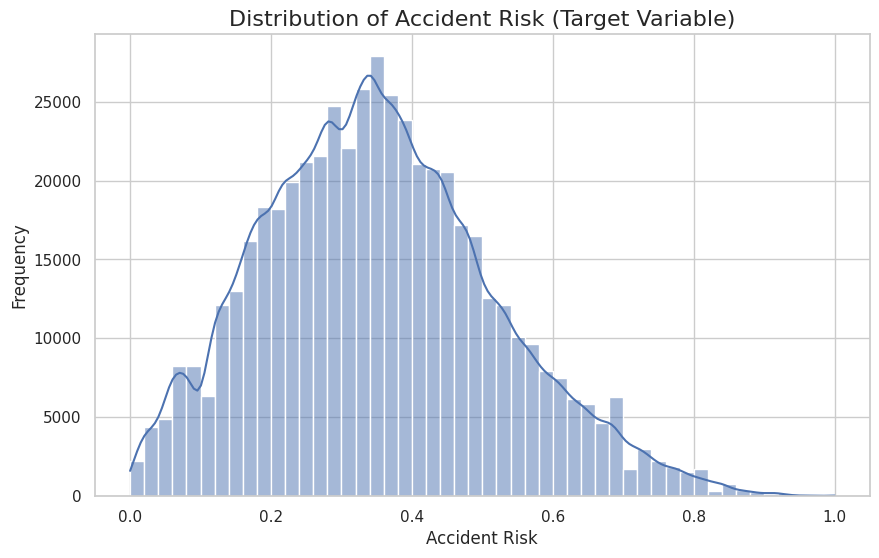

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['accident_risk'], kde=True, bins=50)
plt.title('Distribution of Accident Risk (Target Variable)', fontsize=16)
plt.xlabel('Accident Risk', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('target_distribution.png')
print("Generated target_distribution.png")

Categorical features: ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']
Generated dist_road_type.png
Generated dist_lighting.png
Generated dist_weather.png
Generated dist_road_signs_present.png
Generated dist_public_road.png
Generated dist_time_of_day.png
Generated dist_holiday.png
Generated dist_school_season.png


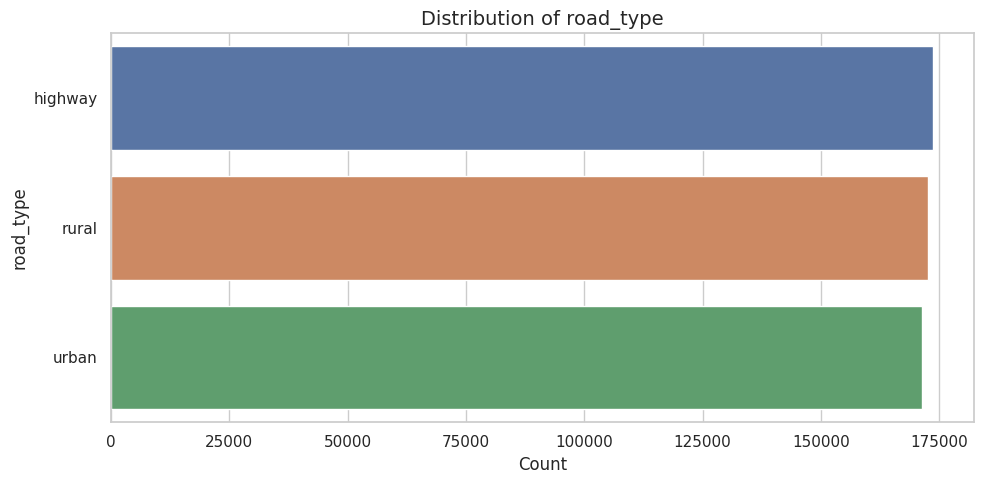

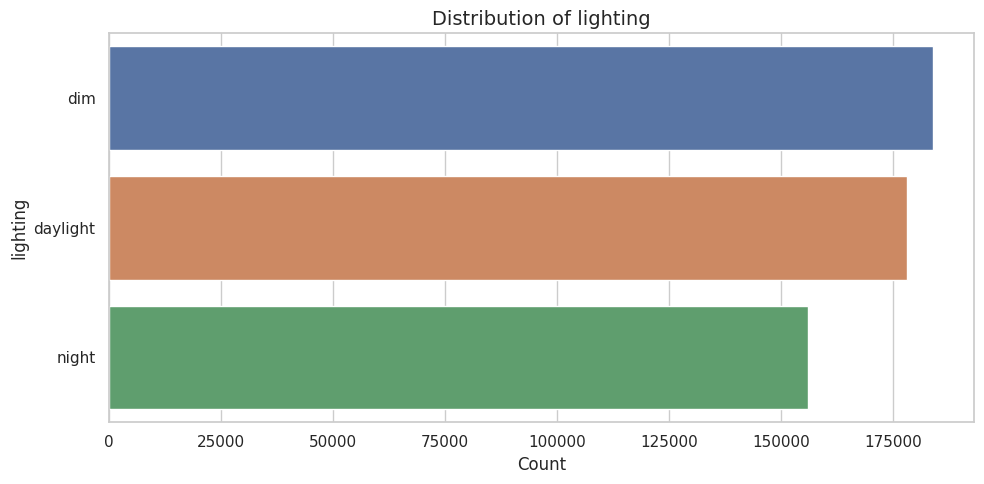

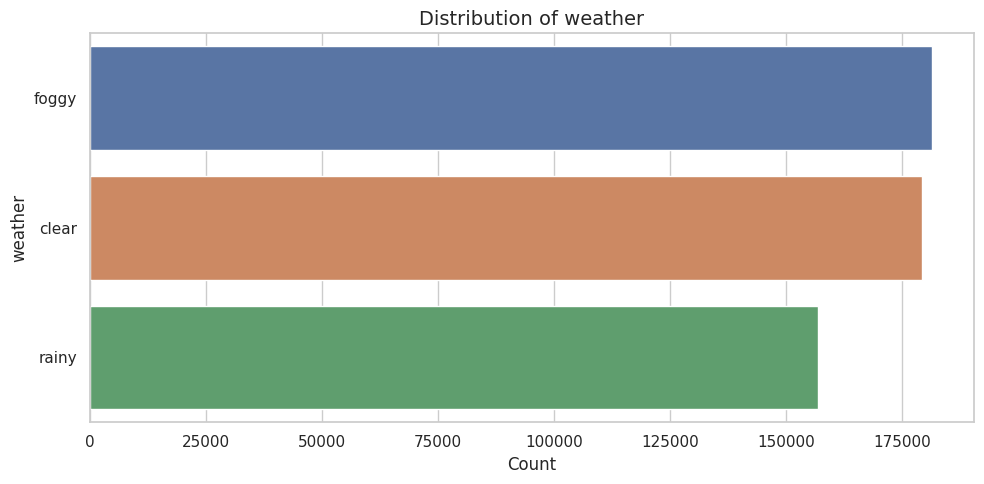

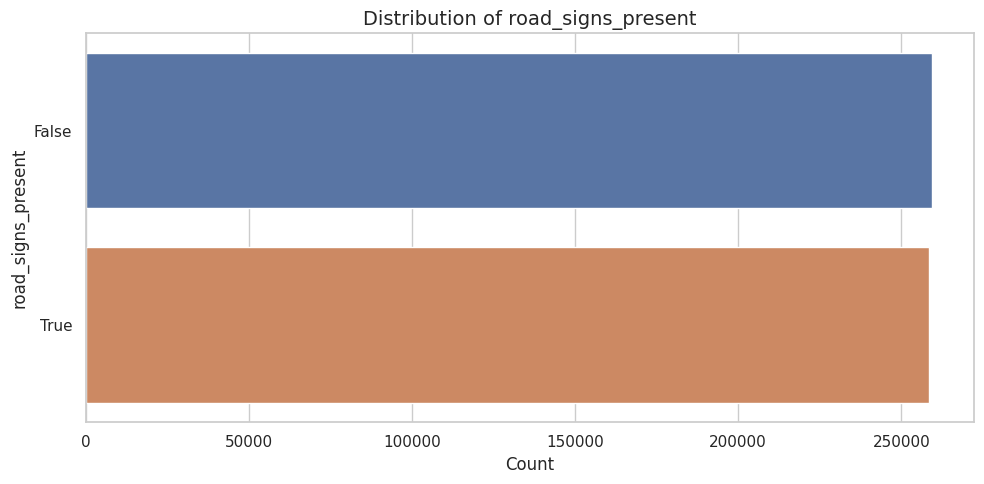

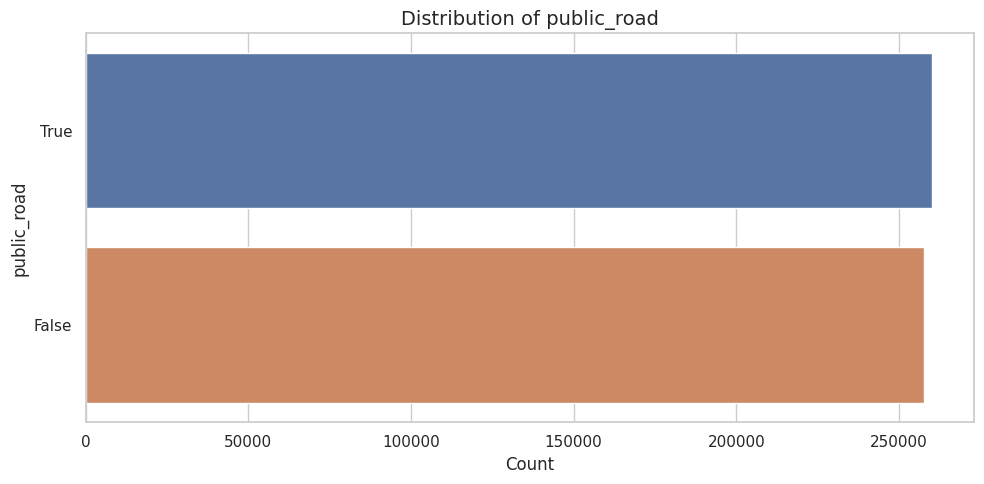

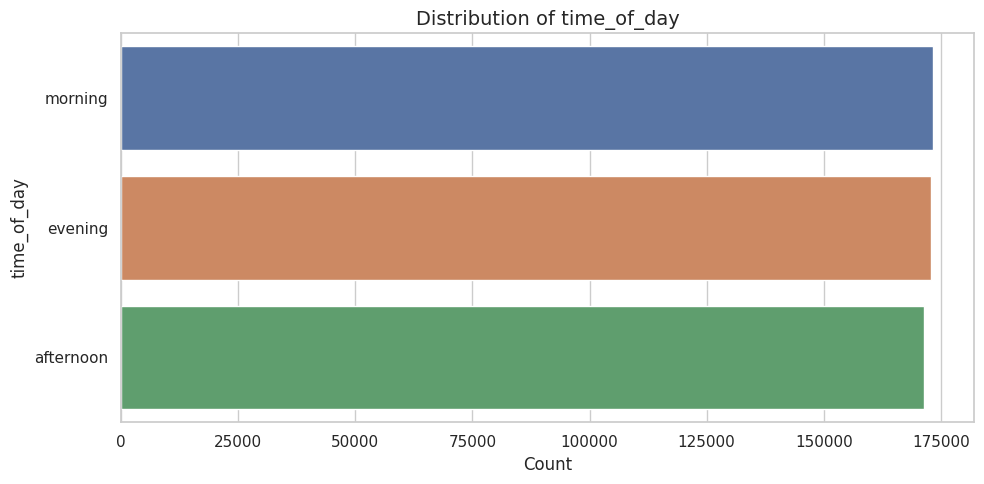

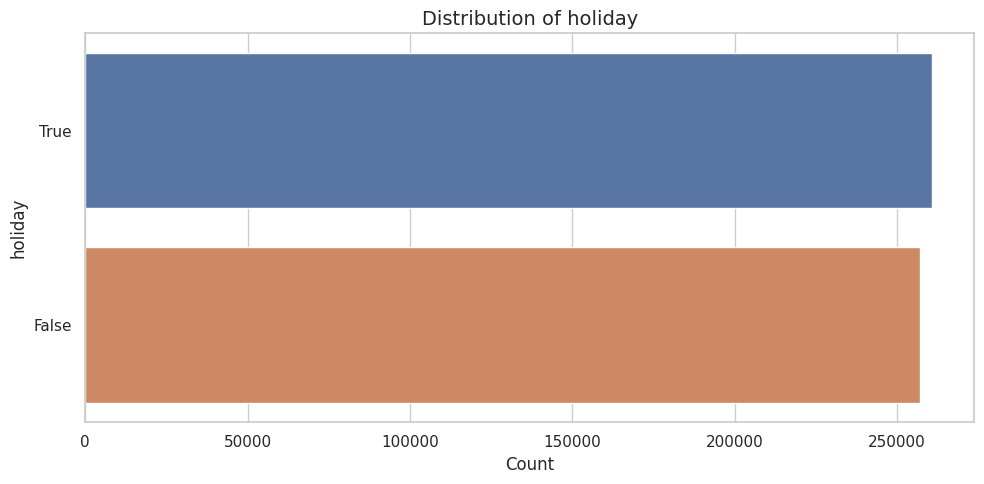

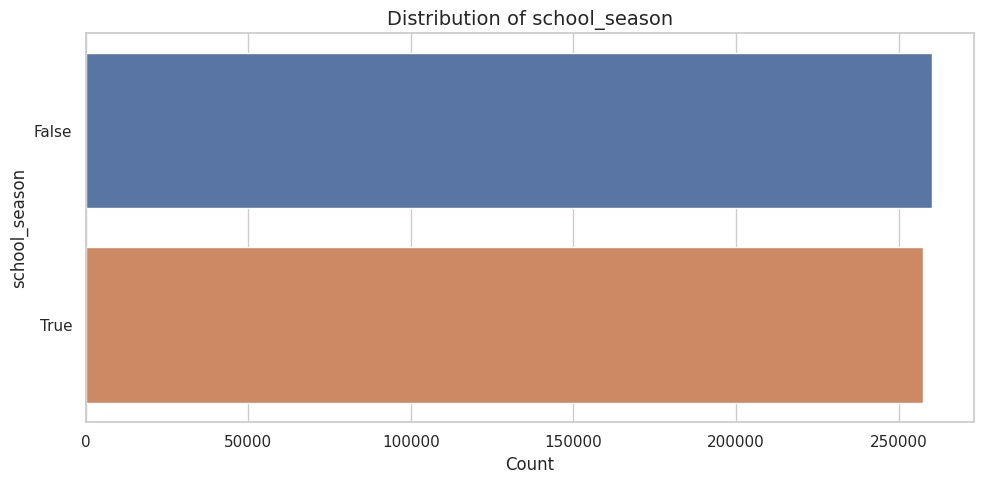

In [7]:
# Identify categorical features (object or boolean type)
categorical_features = train_df.select_dtypes(include=['object', 'bool']).columns

print(f"Categorical features: {list(categorical_features)}")

for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.tight_layout()
    plt.savefig(f'dist_{col}.png')
    print(f"Generated dist_{col}.png")

Numerical features: ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
Generated numerical_features_hist.png
Generated correlation_heatmap.png


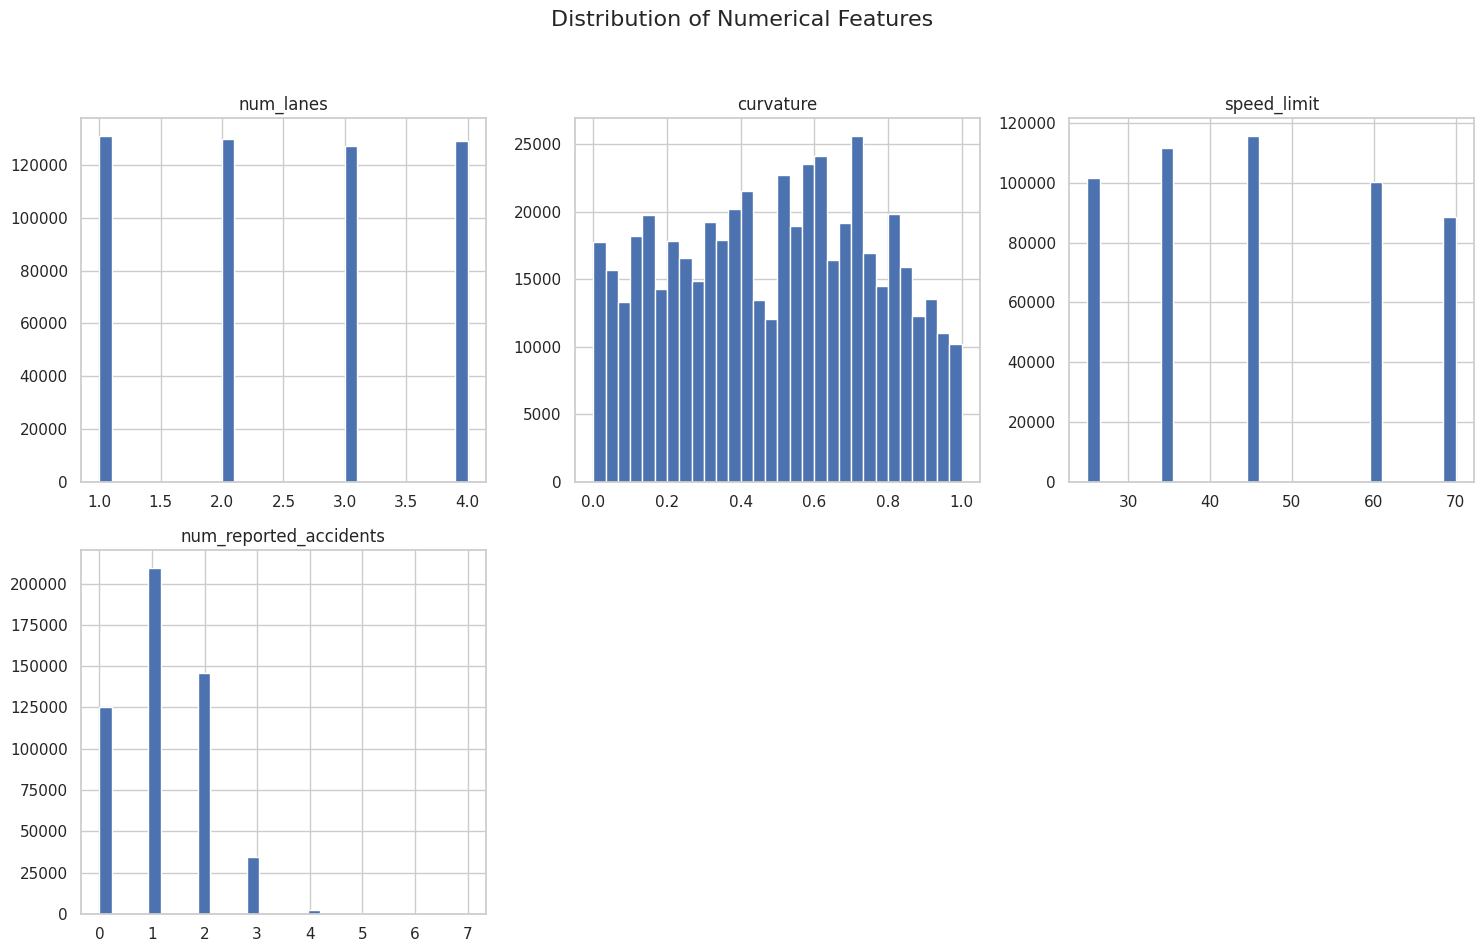

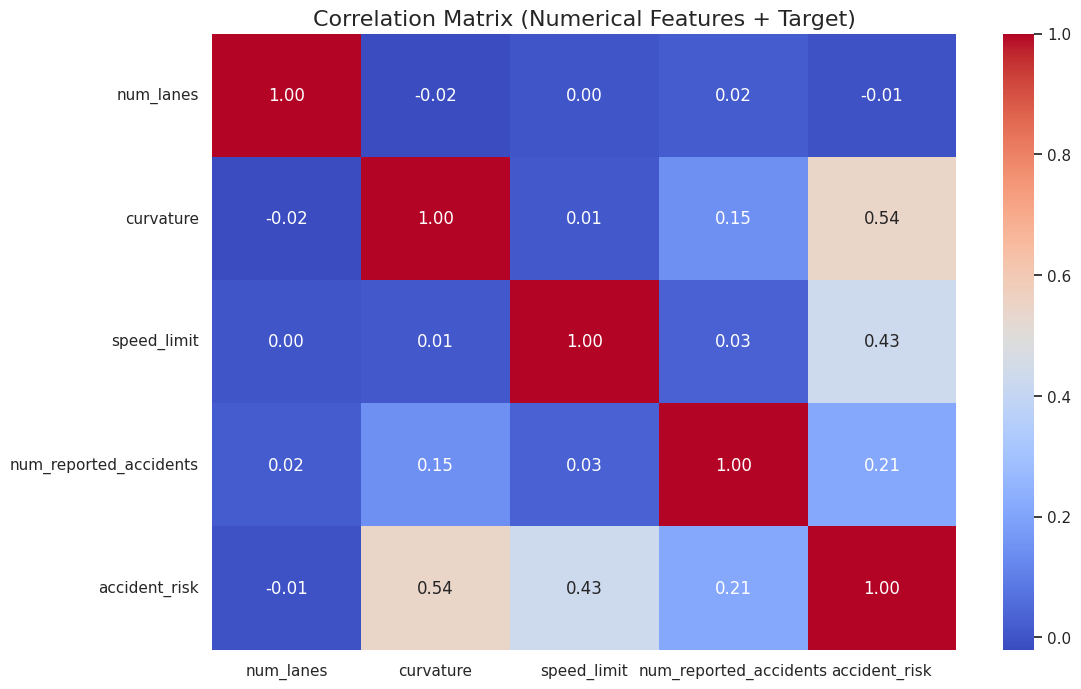

In [8]:
# Identify numerical features
numerical_features = train_df.select_dtypes(include=np.number).columns.drop(['id', 'accident_risk'])
print(f"Numerical features: {list(numerical_features)}")

# Plot histograms for numerical features
train_df[numerical_features].hist(bins=30, figsize=(15, 10), layout=(-1, 3))
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('numerical_features_hist.png')
print("Generated numerical_features_hist.png")

# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = train_df[numerical_features.tolist() + ['accident_risk']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Numerical Features + Target)', fontsize=16)
plt.savefig('correlation_heatmap.png')
print("Generated correlation_heatmap.png")

In [9]:
target = 'accident_risk'
features_to_drop = ['id']

# Create X (features) and y (target)
X = train_df.drop(columns=[target] + features_to_drop)
y = train_df[target]

# Create X_test (test features)
X_test = test_df.drop(columns=features_to_drop)

# Find categorical features
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Convert categorical features to 'category' dtype for LightGBM
print(f"Converting categorical columns: {categorical_cols}")
for col in categorical_cols:
    X[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')

print("\nData types after conversion (Training):")
X.info()

Converting categorical columns: ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']

Data types after conversion (Training):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   road_type               517754 non-null  category
 1   num_lanes               517754 non-null  int64   
 2   curvature               517754 non-null  float64 
 3   speed_limit             517754 non-null  int64   
 4   lighting                517754 non-null  category
 5   weather                 517754 non-null  category
 6   road_signs_present      517754 non-null  category
 7   public_road             517754 non-null  category
 8   time_of_day             517754 non-null  category
 9   holiday                 517754 non-null  category
 10  school_season           517754 non

In [10]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (414203, 12)
Validation data shape: (103551, 12)


In [11]:
# Define the model with optimized parameters
# These parameters are a good starting point for this type of problem
lgb_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=2000,      # High number, will be stopped by early stopping
    learning_rate=0.02,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1
)

print("Starting model training...")
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(100, verbose=100)],
    categorical_feature=categorical_cols
)

# Get the best number of estimators found
best_n_estimators = lgb_model.best_iteration_
print(f"\nBest number of estimators found: {best_n_estimators}")

# Evaluate on validation set
val_preds = lgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"Validation RMSE: {rmse}")

Starting model training...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info] Start training from score 0.352605
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1995]	valid_0's rmse: 0.0562707	valid_0's l2: 0.00316639

Best number of estimators found: 1995
Validation RMSE: 0.056270669606120635


Generated feature_importance.png


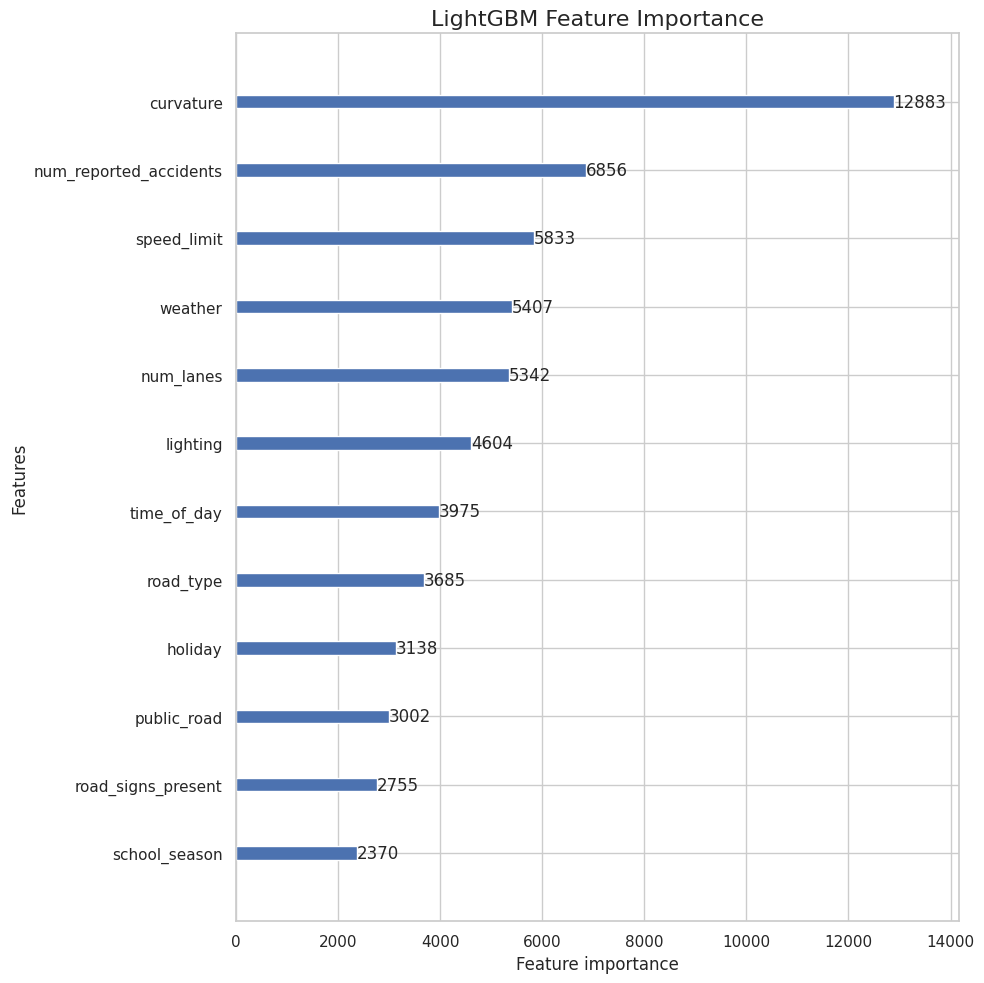

In [12]:
lgb.plot_importance(lgb_model, figsize=(10, 10), max_num_features=20)
plt.title('LightGBM Feature Importance', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance.png')
print("Generated feature_importance.png")

In [13]:
print("Training final model on all data...")

# Initialize final model with the best number of estimators
final_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=best_n_estimators,  # Use the best iteration
    learning_rate=0.02,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1
)

# Train on the full dataset
final_model.fit(
    X, y,
    categorical_feature=categorical_cols
)

print("Final model trained.")

Training final model on all data...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 517754, number of used features: 12
[LightGBM] [Info] Start training from score 0.352377
Final model trained.


In [14]:
print("Making predictions on test data...")
predictions = final_model.predict(X_test)

# Clip predictions to be between 0 and 1, as required
predictions_clipped = np.clip(predictions, 0, 1)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'accident_risk': predictions_clipped
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file created successfully!")
print(submission_df.head())

Making predictions on test data...

Submission file created successfully!
       id  accident_risk
0  517754       0.288381
1  517755       0.125319
2  517756       0.188807
3  517757       0.316549
4  517758       0.396071
